In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [61]:
# Create our session (link) from Python to the DB
session = Session(engine)

inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

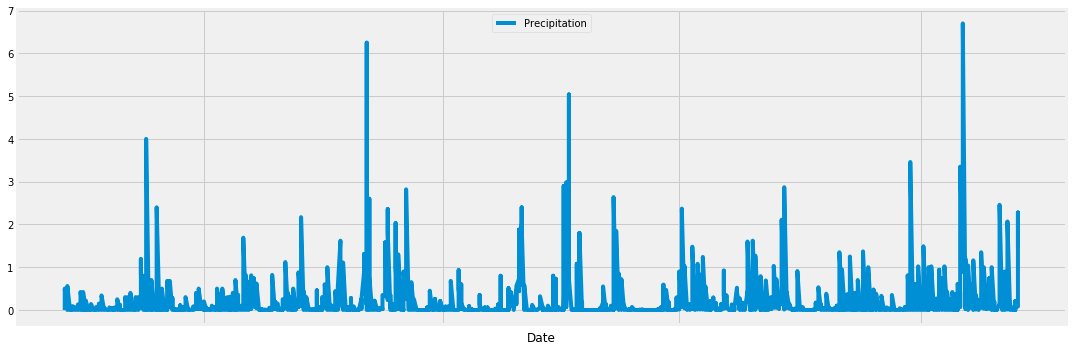

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results#
# Calculate the date 1 year ago from the last data point in the database#
# Perform a query to retrieve the data and precipitation scores#
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data


max_date = max(session.query(measurement.date))[0]

start_date = datetime.strptime(max_date, '%Y-%m-%d').date()

year_ago = start_date - dt.timedelta(days=365)

# print(start_date)
# print(year_ago)


data = session.query(measurement.date,measurement.prcp).filter(measurement.prcp!='None').filter(measurement.date >year_ago).filter(measurement.date<start_date).order_by(measurement.date.desc()).all()


df = pd.DataFrame(data).set_index('date')  
df = df.rename(columns = {'prcp':'Precipitation'})


didx = pd.date_range(start =min(df.index), freq ='Q',periods = 4)
quarts = [x.strftime("%Y-%m-%d") for x in didx]

# quarts

# create table
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 1, 1)     
plt.plot(df.Precipitation, label = 'Precipitation')

# Set major xticks to quarter
ax.set_xticks(quarts, minor = False)

#set gridlines and labels
ax.grid(which = 'major', axis = 'both',alpha = 1)
# plt.ylabel('Precipitation')
plt.xlabel('Date')
ax.set_xticklabels([])
plt.tight_layout()
ax.legend(loc = 'upper center')
plt.savefig('../hw_images/Precipitation_BB.png')
plt.show();

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2011.000000
mean,0.176549
std,0.460667
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?


In [14]:
# Design a query to show how many stations are available in this dataset?
Total_stations = session.query(func.count(station.station)).all()
Total_stations

[(9)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

stations = session.query(measurement.station, func.count(measurement.date)).group_by('station').order_by(func.count(measurement.date).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

temp = measurement.tobs
mactive = stations[0][0]

session.query(func.min(temp),func.max(temp),func.avg(temp)).filter(measurement.station == mactive).all()


[(54.0, 85.0, 71.66378066378067)]

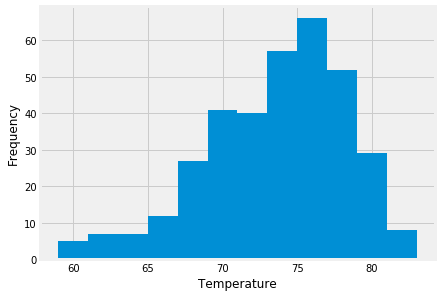

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram



max_date2 = max(session.query(measurement.date).filter(measurement.station == mactive))[0]
max_date2
start_date2 = datetime.strptime(max_date2, '%Y-%m-%d').date()

year_ago2 = start_date2 - dt.timedelta(days=365)

# print('start date: ',max_date)
# print('year ago',year_ago)


temp_LastYear = session.query(measurement.date,temp).filter(measurement.station == mactive).filter(measurement.date>year_ago).filter(measurement.date<max_date).all()

temp_df = pd.DataFrame(temp_LastYear,columns = ['Date','Temp'])


plt.hist(temp_df['Temp'],label = 'Temp', bins = 12);
plt.tight_layout()
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps(year_ago,max_date))


[(58.0, 74.59058295964125, 87.0)]


In [32]:
temp_df.head()

,Date,Temp
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


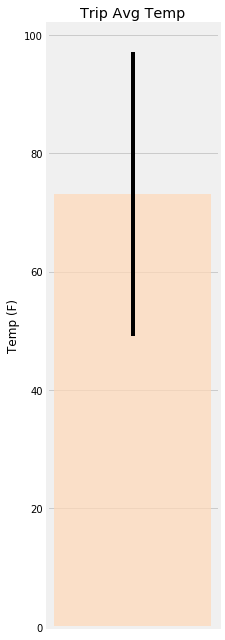

In [60]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


y = temp_df['Temp'].mean()
yerr = temp_df.Temp.max() - temp_df.Temp.min()

fig = plt.figure(figsize=(3,9))
ax = fig.add_subplot(1, 1, 1)  
plt.bar(range(1),y, yerr = yerr, label = 'Temp', color =[(1,.85,.72)],alpha = 0.7);
ax.set_xticklabels([])
plt.title("Trip Avg Temp")
plt.tight_layout()
plt.ylabel('Temp (F)')
plt.grid(axis = 'x')
plt.show()

<IPython.core.display.Javascript object>


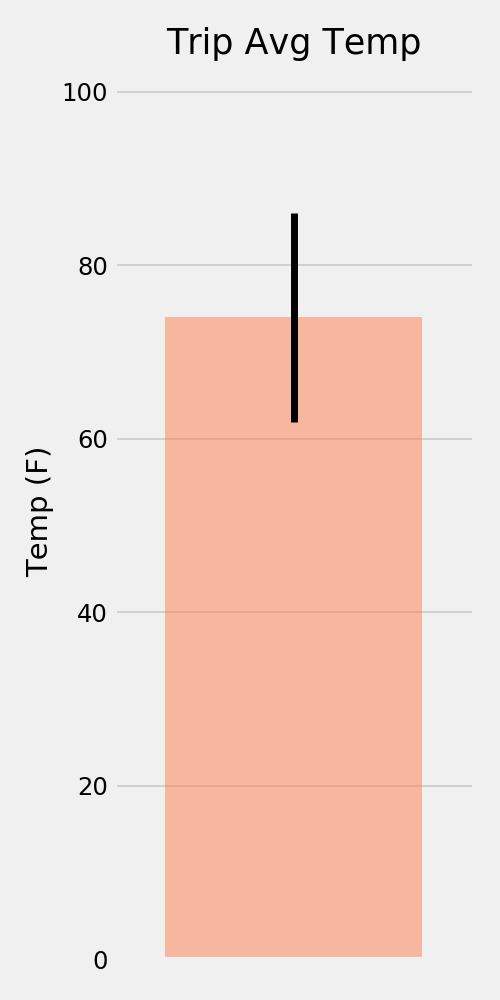

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)




In [ ]:
measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT

In [68]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall = session.query(measurement.station, station.name, station.latitude, station.longitude,station.elevation,func.sum(measurement.prcp)).filter(measurement.date>year_ago).filter(measurement.date<max_date).filter(measurement.station == station.station).group_by('station').order_by(func.sum(measurement.prcp).desc()).all()
print(rainfall)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 146.66000000000005), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 68.24000000000002), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 48.36000000000003), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 37.910000000000004), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 33.19), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 16.089999999999986), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 4.59)]


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [82]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = max_date
end_date =  year_ago

# Use the start and end date to create a range of dates
dates = session.query(measurement.date).filter(measurement.date<start_date).filter(measurement.date>end_date).all()

# Stip off the year and save a list of %m-%d strings

for date in dates:
#     dates2 = datetime.strptime(date, '%m-%d').date()
    print(datetime.strptime(date, '%m-%d').date())



# Loop through the list of %m-%d strings and calculate the normals for each date


TypeError: strptime() argument 1 must be str, not result

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`


# Set the start and end date of the trip

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings


# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


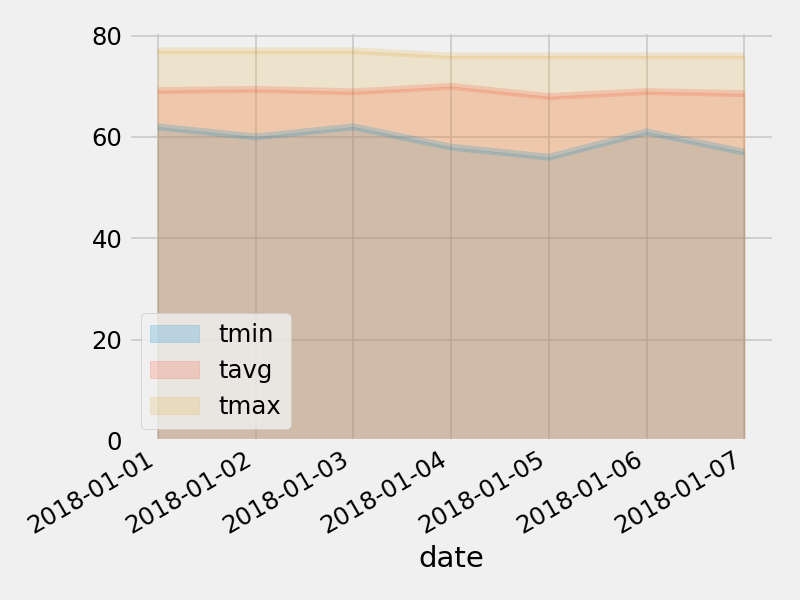

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
